In [2]:
from pprint import pprint
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError

import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
def get_variables_and_size():
    from sys import getsizeof
    names = []
    sizes = []
    types = []
    for name in dir():
        # Print the item if it doesn't start with '__'
        if not name.startswith('__'):
            value = eval(name)
            names.append(name)
            sizes.append(getsizeof(value))
            types.append(type(value))
    sort_indexes = np.argsort(sizes)[::-1]
    names = np.array(names)[sort_indexes]
    sizes = np.array(sizes)[sort_indexes]
    types = np.array(types)[sort_indexes]
    for n,s,t in zip(names,sizes,types):
        print(n, "\n\tsize :", s, "\n\ttype :", t)

# Load the dataset

In [3]:
df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final_by_day.zip")
# df_train = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2016_final.zip")
df_train["raining"] = df_train["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_train["not_raining"] = 1-df_train["raining"]

x_train, y_reg_train, y_cls_train = df_train.drop(["ground_truth","not_raining","raining"], axis=1), df_train["ground_truth"], df_train[["not_raining","raining"]].to_numpy()
del df_train

In [4]:
df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final_by_day.zip")
# df_test = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_2017_final.zip")
# get rows for computing MAPE on test
prediction_x_test = pd.DataFrame(df_test[["Id","ground_truth"]])

df_test["raining"] = df_test["ground_truth"].apply(lambda x : 0 if (x==0) else 1)
df_test["not_raining"] = 1-df_test["raining"]

x_test, y_reg_test, y_cls_test = df_test.drop(["ground_truth","not_raining","raining"], axis=1), df_test["ground_truth"], df_test[["not_raining","raining"]].to_numpy()
del df_test

# Add classification label (raining or not)

In [5]:
# define the unnecessary columns
cols_to_drop = {"day","Id", "station_id","month","longitude_idx","latitude_idx", "next hour precipitation (kg/m^2)", "wind_direction (deg)"}

In [6]:
#drop unnecessary columns
x_train.drop(list(set(x_train.columns)&cols_to_drop), axis=1, inplace=True)

In [7]:
#drop unnecessary columns
x_test.drop(list(set(x_test.columns)&cols_to_drop), axis=1, inplace=True)


# get same columns on both datasets

In [8]:
columns = list(x_train.columns)
x_train = x_train[columns]
x_test = x_test[columns]

# normalize both dataset with 2016 min and min-max values

In [9]:
def get_normalization_infos(*x_s, columns):
    normalization_infos = pd.DataFrame(data=[[1000 for _ in range(len(columns))],[0 for _ in range(len(columns))]],
                                     index=["min","max"],
                                     columns=columns)
    for x in x_s :
        for col in columns:
            min_value = min(normalization_infos[col]["min"], x[col].min())
            max_value = max(normalization_infos[col]["max"], x[col].max())
            normalization_infos[col] = [min_value, max_value]

    normalization_infos.loc["spread"] = normalization_infos.apply(lambda c : c["max"] - c["min"], axis=0)

    return normalization_infos

normalization_infos = get_normalization_infos(x_train, x_test, columns=columns)

In [10]:
def normalize(x : pd.DataFrame, normalization_infos : pd.DataFrame):
    for col in x.columns:
        x[col] = (x[col] - normalization_infos[col]["min"])/normalization_infos[col]["spread"]
    return x

x_train = normalize(x_train, normalization_infos)
x_test = normalize(x_test, normalization_infos)

# see if the data is balanced raining-wise

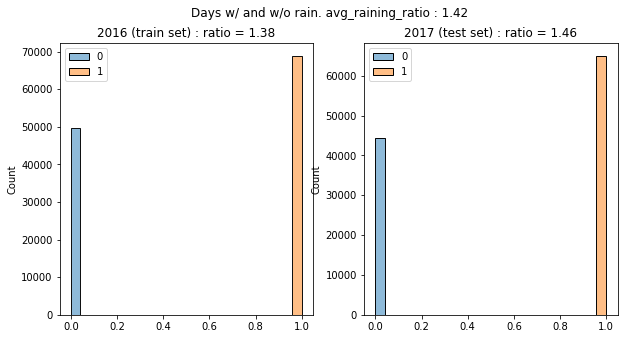

In [11]:
raining_ratio1 = y_cls_train[:,1].sum()/y_cls_train[:,0].sum()
raining_ratio2 = y_cls_test[:,1].sum()/y_cls_test[:,0].sum()
avg_raining_ratio = (raining_ratio1+raining_ratio2)/2

plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
sns.histplot(x=y_cls_train[:,1],hue=y_cls_train[:,1])
plt.title("2016 (train set) : ratio = {:.2f}".format(raining_ratio1))
plt.subplot(1,2,2)
sns.histplot(x=y_cls_test[:,1], hue=y_cls_test[:,1])
plt.title("2017 (test set) : ratio = {:.2f}".format(raining_ratio2))
plt.suptitle("Days w/ and w/o rain. avg_raining_ratio : {:.2f}".format(avg_raining_ratio))
plt.show()

ratio = 0.13 for both 2016 and 2017 ==> **Unbalanced**

# Classification Model (raining or not)
source : https://thinkingneuron.com/how-to-use-artificial-neural-networks-for-classification-in-python/

In [12]:
# Creating model using the Sequential in tensorflow
def build_model_classf(*hidden_units, input_dim=106, loss ='binary_crossentropy', metrics = ("AUC","accuracy")):
    model = Sequential()
    model.add(Dense(hidden_units[0], input_dim=input_dim, activation="relu",))
    for hu in hidden_units[1:]:
        model.add(Dropout(0.2))
        model.add(Dense(hu, activation="relu"))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        loss=loss,
        optimizer=Adam(learning_rate=0.001),
        metrics=metrics
    )

    print(model.summary())
    return model

In [13]:
# build the model
model_cls = build_model_classf(32,16,16,input_dim=x_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3136      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 3,970
Trainable params: 3,970
Non-trainabl

2022-01-08 23:39:53.675184: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-08 23:39:53.718441: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-01-08 23:39:53.718467: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-01-08 23:39:53.718765: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [14]:
# train the model
history_cls = model_cls.fit(
    x=x_train.values,
    y=y_cls_train,
    epochs=25,
    batch_size=64,
    # validation_split=0.15
    validation_data=(x_test,y_cls_test)
    )

Epoch 1/25
1823/1854 [============================>.] - ETA: 0s - loss: 0.6176 - auc: 0.7200 - accuracy: 0.6655

2022-01-08 23:39:58.461079: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84833872 exceeds 10% of free system memory.


1854/1854 [==============================] - 6s 3ms/step - loss: 0.6173 - auc: 0.7205 - accuracy: 0.6659 - val_loss: 0.6257 - val_auc: 0.7102 - val_accuracy: 0.6521
Epoch 2/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.5972 - auc: 0.7453 - accuracy: 0.6857 - val_loss: 0.6268 - val_auc: 0.7101 - val_accuracy: 0.6522
Epoch 3/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.5904 - auc: 0.7532 - accuracy: 0.6911 - val_loss: 0.6248 - val_auc: 0.7095 - val_accuracy: 0.6510
Epoch 4/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.5863 - auc: 0.7578 - accuracy: 0.6937 - val_loss: 0.6356 - val_auc: 0.7024 - val_accuracy: 0.6508
Epoch 5/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.5834 - auc: 0.7610 - accuracy: 0.6970 - val_loss: 0.6365 - val_auc: 0.7084 - val_accuracy: 0.6530
Epoch 6/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.5816 - auc: 0.7632 - accuracy: 0.6988 - val_loss: 0.6

In [15]:
def plot_history_cls(history, loss, key1, key2):
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(list(range(len(history.history["loss"]))))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])

    plt.subplot(1,3,2)
    plt.title("metric : {}".format(key1))
    plt.plot(history.history[key1])
    plt.plot(history.history['val_'+key1])
    plt.xlabel("Epochs")
    plt.xticks(list(range(len(history.history["loss"]))))
    # plt.ylabel(key1)
    plt.legend([key1, 'val_'+key1])

    plt.subplot(1,3,3)
    plt.title("metric : {}".format(key2))
    plt.plot(history.history[key2.lower()])
    plt.plot(history.history['val_'+key2.lower()])
    plt.xlabel("Epochs")
    plt.xticks(list(range(len(history.history["loss"]))))
    # plt.ylabel(key2)
    plt.legend([key2, 'val_'+key2])

    plt.suptitle("Classification results")
    plt.show()

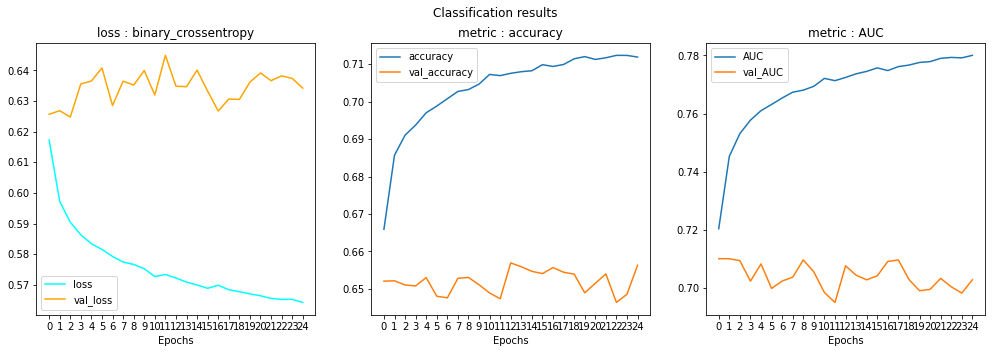

In [16]:
# Plot the history
plot_history_cls(history_cls, loss = "binary_crossentropy", key1 = 'accuracy', key2 = 'AUC')

# Regression Model (how much rain if > 0)
source : https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

In [17]:
# Creating model using the Sequential in tensorflow
def build_model_regrs(*hidden_units, input_dim=106, metric = MeanSquaredError()):
    model = Sequential()
    model.add(Dense(hidden_units[0], input_dim=input_dim, activation="relu",))
    for hu in hidden_units[1:]:
        model.add(Dropout(0.2))
        model.add(Dense(hu, activation="relu"))
    model.add(Dense(1, activation='relu'))

    model.compile(
        loss=metric,
        optimizer=Adam(learning_rate=0.001),
        metrics=[metric]
    )

    print(model.summary())
    return model

In [18]:
# build the model
model_reg = build_model_regrs(32,16,16,input_dim=x_train.shape[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 3,953
Trainable params: 3,953
Non-traina

In [19]:
# train the model
history_reg = model_reg.fit(
    x=x_train.values,
    y=y_reg_train.values,
    epochs=25,
    batch_size=64,
    # validation_split=0.15
    validation_data=(x_test,y_reg_test)
)

Epoch 1/25
1820/1854 [============================>.] - ETA: 0s - loss: 0.0328 - mean_squared_error: 0.0328

2022-01-08 23:41:40.358809: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84833872 exceeds 10% of free system memory.


1854/1854 [==============================] - 4s 2ms/step - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 2/25
1854/1854 [==============================] - 3s 2ms/step - loss: 0.0312 - mean_squared_error: 0.0312 - val_loss: 0.0290 - val_mean_squared_error: 0.0290
Epoch 3/25
1854/1854 [==============================] - 3s 2ms/step - loss: 0.0307 - mean_squared_error: 0.0308 - val_loss: 0.0293 - val_mean_squared_error: 0.0293
Epoch 4/25
1854/1854 [==============================] - 3s 2ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0289 - val_mean_squared_error: 0.0289
Epoch 5/25
1854/1854 [==============================] - 3s 2ms/step - loss: 0.0304 - mean_squared_error: 0.0304 - val_loss: 0.0294 - val_mean_squared_error: 0.0294
Epoch 6/25
1854/1854 [==============================] - 4s 2ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0286 - val_mean_squared_error: 0.0286
Epoch 7/25
1854/1854 [=====

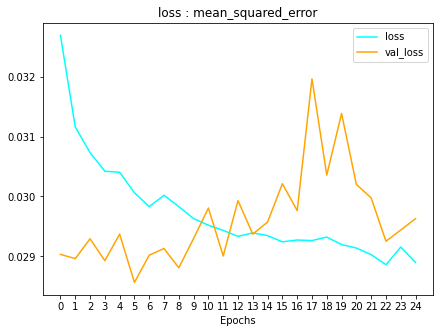

In [20]:
def plot_history_reg(history, loss : str):
    plt.figure(figsize=(7,5))
    plt.title("loss : {}".format(loss))
    plt.plot(history.history["loss"], c="cyan")
    plt.plot(history.history["val_loss"], c="orange")
    plt.xlabel("Epochs")
    plt.xticks(list(range(len(history.history["loss"]))))
    # plt.ylabel("loss")
    plt.legend(["loss", "val_loss"])
    plt.show()
# Plot the history
plot_history_reg(history_reg, 'mean_squared_error')

# Compute MAPE on 2017 dataset before submitting

In [20]:
del x_train
del y_cls_train
del y_reg_train

In [21]:
y_cls_pred = model_cls.predict(x_test)

2022-01-08 23:43:29.923884: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84833872 exceeds 10% of free system memory.


In [22]:
y_reg_pred = model_reg.predict(x_test)

2022-01-08 23:43:32.650173: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 84833872 exceeds 10% of free system memory.


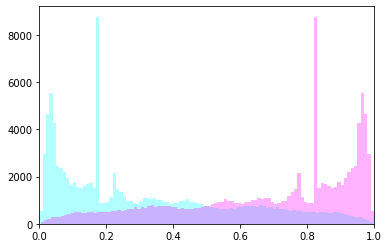

In [23]:
plt.hist(y_cls_pred[:,0], color="cyan", alpha=0.3, bins=100)
plt.hist(y_cls_pred[:,1], color="magenta", alpha=0.3, bins=100)
plt.xlim([0,1])
plt.show()

In [24]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([[0,1] if c else [1,0] for c in cls_temp])

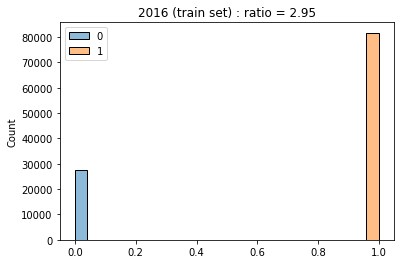

In [25]:
raining_ratio_pred = y_cls_pred[:,1].sum()/y_cls_pred[:,0].sum()
plt.title("2016 (train set) : ratio = {:.2f}".format(raining_ratio_pred))
sns.histplot(x=y_cls_pred[:,1],hue=y_cls_pred[:,1])
plt.show()

In [26]:
y_reg_pred.max()

0.69625604

# define threshold to split y_reg_pred in order to retrieve same raining_ratio as for 2017

In [ ]:
def dichotomie(a,b,e,f):
    delta = 1
    while delta > e:
        m = a + (b - a) / 2
        delta = abs(b - a)
        print("{:15} , {:15} , {:15} , {:15} , {:15} , {:15} , {:15} ".format(a,b,m,f(a),f(b),f(m),delta) )
        if f(m) == 0:
            return m
        elif f(a) * f(m)  > 0:
            a = m
        else:
            b = m
    return a, b, delta

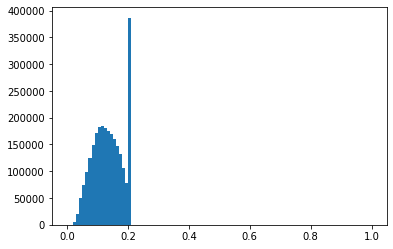

In [25]:
plt.hist(y_cls_pred, bins=100, range=(0,1))
plt.show()

x_test raining ratio : 0.13


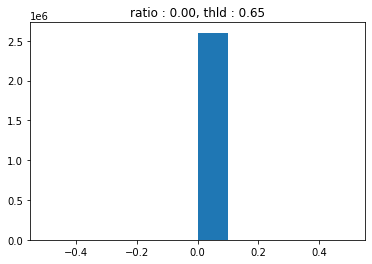

In [26]:
print("x_test raining ratio : {:.2f}".format(avg_raining_ratio))
thld = 0.65
array = np.array([0 if y <= thld else 1 for y in y_cls_pred])
ratio = array.sum()/(len(array)-array.sum())
plt.hist(array)
plt.title("ratio : {:.2f}, thld : {:.2f}".format(ratio, thld))
plt.show()    # train the model
history_cls = model_cls.fit(
    x=x_train.values,
    y=y_cls_train,
    epochs=5,
    batch_size=64,
    # validation_split=0.15
    validation_data=(x_test,y_cls_test)
)

==> keep ratio = 0.12 and thld = 0.18

In [27]:
y_cls_pred_bkp = np.array(y_cls_pred)

In [28]:
y_cls_pred = np.array([0 if y <= thld else 1 for y in y_cls_pred])

In [26]:
prediction_x_test["reg_pred"] = pd.Series(y_reg_pred.T[0])

In [27]:
prediction_x_test["cls_pred"] = y_cls_pred

ValueError: Wrong number of items passed 2, placement implies 1

In [28]:
prediction_x_test["Prediction"] = prediction_x_test["reg_pred"] * prediction_x_test["cls_pred"]

KeyError: 'cls_pred'

In [32]:
prediction_x_test.head()

,Id,ground_truth,reg_pred,cls_pred,Prediction
0,86118001_366,0.0,0.06694,0,0.0
1,86118001_366,0.0,0.06694,0,0.0
2,86118001_366,0.0,0.06694,0,0.0
3,86118001_366,0.0,0.06694,0,0.0
4,86118001_366,0.0,0.06694,0,0.0


In [33]:
def m_mape(y_true,y_predict):
    n = len(y_true)
    y_true = np.array(y_true) + 1
    y_predict = np.array(y_predict) + 1

    res = ((100/n)*(np.sum(np.abs((y_predict-y_true)/y_true))))
    return res

In [34]:
m_mape(prediction_x_test["ground_truth"],prediction_x_test["Prediction"])

3.6189836717722814

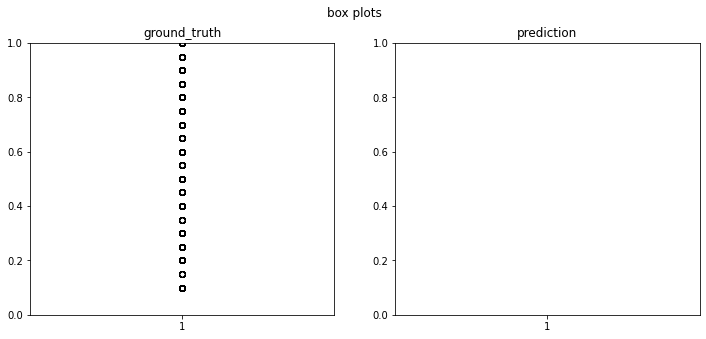

In [35]:
plt.figure(figsize=(12,5))
plt.suptitle("box plots")
plt.subplot(1,2,1)
plt.title("ground_truth")
plt.boxplot(prediction_x_test["ground_truth"])
plt.ylim([0,1])
plt.subplot(1,2,2)
plt.title("prediction")
plt.boxplot(prediction_x_test["Prediction"])
plt.ylim([0,1])
plt.show()

In [36]:
print(prediction_x_test["Prediction"].min(),prediction_x_test["Prediction"].mean(),prediction_x_test["Prediction"].max())

0.0 0.0 0.0


In [ ]:
del x_train
del y_cls_train
del y_reg_train

del x_test
del y_cls_test
del y_reg_test

# Make a submission

In [29]:
test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final_by_day.zip")
# test_set = pd.read_csv("../preprocessed_data_Defi-IA-2022-Rain-Frogs/X_all_test_final.zip")

## create submission dataset

In [30]:
submission = pd.DataFrame(test_set[["Id"]])

## get same columns as before for test_set

In [31]:
test_set = test_set[columns]

## normalize same way test_set

In [32]:
test_set = normalize(test_set,normalization_infos)

In [33]:
test_set.head()

,altitude (m),latitude,longitude,month_cos,month_sin,current hour precipitations (kg/m^2),wind_direction_cos,wind_direction_sin,wind_speed (m/s),wind_component_u (m/s),...,3D_Arpege_isobar_600hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_600hpa_Geopotential (m^2/s^2),3D_Arpege_isobar_500hpa_Temperature (K),3D_Arpege_isobar_500hpa_RelavtiveHumidity (%),3D_Arpege_isobar_500hpa_WindSpeed (m/s),3D_Arpege_isobar_500hpa_WindDirection (deg),3D_Arpege_isobar_500hpa_WindComponentU (m/s),3D_Arpege_isobar_500hpa_WindComponentV (m/s),3D_Arpege_isobar_500hpa_VerticalVelocity (Pa/s),3D_Arpege_isobar_500hpa_Geopotential (m^2/s^2)
0,0.152632,0.75,0.833333,0.000000,0.500000,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.609439,0.944588,0.580973,0.679873,0.158791,0.679938,0.513694,0.603836,0.584511,0.948570
1,0.152632,0.75,0.833333,0.750000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.592835,0.987683,0.851050,0.243663,0.169768,0.688638,0.520906,0.601052,0.569387,0.989601
2,0.152632,0.75,0.833333,0.933013,0.250000,0.09375,0.335841,0.972284,0.096735,0.43423,...,0.538019,0.905300,0.271608,0.536040,0.349677,0.700741,0.613256,0.614223,0.542626,0.909959
3,0.152632,0.75,0.833333,0.250000,0.933013,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.519587,0.894589,0.461949,0.822743,0.648840,0.583620,0.614184,0.950458,0.521686,0.907201
4,0.152632,0.75,0.833333,0.066987,0.250000,0.00000,0.335841,0.972284,0.096735,0.43423,...,0.607175,0.947055,0.602551,0.339574,0.163890,0.669567,0.503793,0.610642,0.536338,0.950927


## Predict test_set for submission

In [34]:
y_cls_pred = model_cls.predict(test_set)

2022-01-08 23:44:29.413483: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 91548600 exceeds 10% of free system memory.


In [35]:
y_reg_pred = model_reg.predict(test_set)

In [36]:
cls_temp = y_cls_pred[:,0] < y_cls_pred[:,1]
y_cls_pred = np.array([[0,1] if c else [1,0] for c in cls_temp])

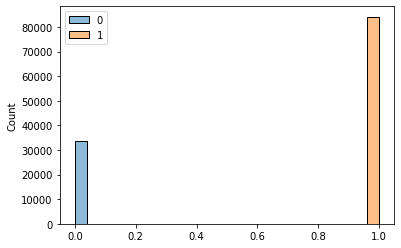

In [37]:
sns.histplot(x=y_cls_pred[:,1], hue=y_cls_pred[:,1])
plt.show()

In [38]:
print(avg_raining_ratio)

1.4240234351648864


In [39]:
submission["cls_pred"] = pd.Series(y_cls_pred.T[0])
submission["reg_pred"] = y_reg_pred

In [40]:
submission["Prediction"] = submission["cls_pred"] * submission["reg_pred"]

In [41]:
submission.head(50)

,Id,cls_pred,reg_pred,Prediction
0,14047002_1,0,0.052582,0.000000
1,14047002_10,1,0.062519,0.062519
2,14047002_100,0,0.152618,0.000000
3,14047002_101,0,0.130004,0.000000
4,14047002_102,0,0.056390,0.000000
5,14047002_103,0,0.130004,0.000000
6,14047002_104,0,0.130004,0.000000
7,14047002_105,0,0.229559,0.000000
8,14047002_106,0,0.130004,0.000000
9,14047002_107,0,0.122883,0.000000


In [42]:
submission[["Id","Prediction"]].to_csv("../submissions/submission_ann.csv", index=False)

lon_idx lat_idx id month penser à normaliser les datasets avec les valeurs max d'un des dataset